<a href="https://colab.research.google.com/github/djibril6/AI-Notebook/blob/main/InceptionV3__Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Loading

In [31]:
zip_path = '/content/drive/MyDrive/blog/article 1/dataset/cats-vs-dogs.zip'
_zip = zipfile.ZipFile(zip_path , "r")
_zip.extractall("/tmp/cats-vs-dogs")
_zip.close()

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (250, 250)
N_EPOCHS = 5

## The data preprossessing

In [5]:
train_generator = ImageDataGenerator(rescale=1.0/255.0)
test_generator = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_generator.flow_from_directory(
    '/tmp/cats-vs-dogs/train',
    batch_size  = BATCH_SIZE,
    class_mode  = 'binary', 
    target_size = IMAGE_SIZE
)

validation_data = test_generator.flow_from_directory(
    '/tmp/cats-vs-dogs/validation',
    batch_size  = BATCH_SIZE,
    class_mode  = 'binary', 
    target_size = IMAGE_SIZE
)

Found 22000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


## Model building and training

In [6]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,)
)
base_model.trainable = False
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
______________________

In [7]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              75498496  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 97,302,305
Trainable params: 75,499,521
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history = model.fit(
    train_data,
    epochs=N_EPOCHS,
    # callbacks=[lr_schedule],
    validation_data=validation_data
)

Epoch 1/5
688/688 [==============================] - 100s 145ms/step - loss: 0.0228 - accuracy: 0.9935 - val_loss: 0.0443 - val_accuracy: 0.9887
Epoch 2/5
688/688 [==============================] - 99s 143ms/step - loss: 0.0230 - accuracy: 0.9941 - val_loss: 0.0404 - val_accuracy: 0.9887
Epoch 3/5
688/688 [==============================] - 99s 143ms/step - loss: 0.0216 - accuracy: 0.9943 - val_loss: 0.0579 - val_accuracy: 0.9880
Epoch 4/5
688/688 [==============================] - 98s 143ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0934 - val_accuracy: 0.9823
Epoch 5/5
688/688 [==============================] - 98s 143ms/step - loss: 0.0259 - accuracy: 0.9951 - val_loss: 0.1365 - val_accuracy: 0.9900


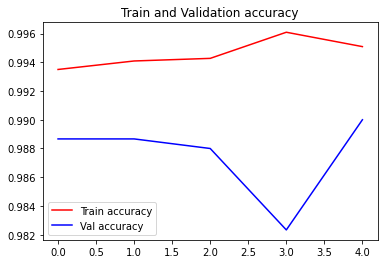

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Val accuracy')
plt.title('Train and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

## Testing

In [38]:
import numpy as np
import shutil

from google.colab import files
from keras.preprocessing import image

# upload some cats and dogs images for testing
allupload=files.upload()

# move all uploaded files to a test directory
test_dir = '/content/test/test/'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
for file_name in allupload.keys():
  path='/content/' + file_name
  shutil.move(path, test_dir)


test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_data = test_gen.flow_from_directory(
    '/content/test/',
    batch_size=32,
    shuffle=False,
    class_mode=None,
    target_size=(IMAGE_SIZE)
)

test_data.filenames

predictions = model.predict(test_data)
pred_labels = dict()
for el, f_name in zip(predictions, test_data.filenames):
  if el[0] > 0.5:
    pred_labels[f_name.split('/')[1]] = 'Dog'
  else:
    pred_labels[f_name.split('/')[1]] = 'Cat'

print(pred_labels)

# romove all uploaded files
for fl in test_data.filenames:
  os.remove('/content/test/'+fl)

Found 9 images belonging to 2 classes.
{'cat.10.jpg': 'Cat', 'cat.6.jpg': 'Cat', 'cat.8.jpg': 'Cat', 'cat.9.jpg': 'Cat', 'dog.3002.jpg': 'Dog', 'dog.3003.jpg': 'Dog', 'dog.3006.jpg': 'Dog', 'dog.3007.jpg': 'Dog', 'dog.3010.jpg': 'Dog'}
